# 0. Introduction

**Dataset**  
- creditcard

**Environment**
- macOS `x86`cpu

**Framework**  
- TensorFlow: Version `2.10.0`

**Dependencies**  
- Python: Version `3.9.18`
- Numpy: Version `1.26.4`
- Pandas: Version `2.2.2`
- Matplotlib: Version `3.9.2`
- scikit-learn: Version `1.5.1`

**Purpose**
- creditcard dataset에는 transaction이 정상적으로 수행된 sample(Class = 0)과 그렇지 않은 sample(Class = 1)이 있다.
- 기본적인 Autoencoder model을 통해 정상적으로 수행된 sample에 대해서만 reconstruction error를 줄이는 방향으로 학습시킨다.
- 이후에 threshold 값을 정한 뒤에 model에 unseen data를 통과시키고, 이를 초과하는 unseen data에 대해서는 Class 1로 분류하여 비정상적인 transaction을 감지할 수 있도록 한다.

**References**  
- [AI-class/AE_credit.ipynb at main · MyungKyuYi/AI-class](https://github.com/MyungKyuYi/AI-class/blob/main/AE_credit.ipynb)

# 1. Load the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('./datasets/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.shape

(284807, 31)

In [4]:
# missing value가 있다면 해당 column만 출력
if (df.isnull().sum().sum() == 0):
    print('no missing values')
else:
    df[df.isnull().sum() != 0]

no missing values


In [5]:
# label 확인 - sol1
print(f'label count: {np.unique(df["Class"], return_counts=True)} \n')
print(f'positive class ratio = {(df[df["Class"] == 1].shape[0] / df.shape[0]):.6f}')

label count: (array([0, 1]), array([284315,    492])) 

positive class ratio = 0.001727


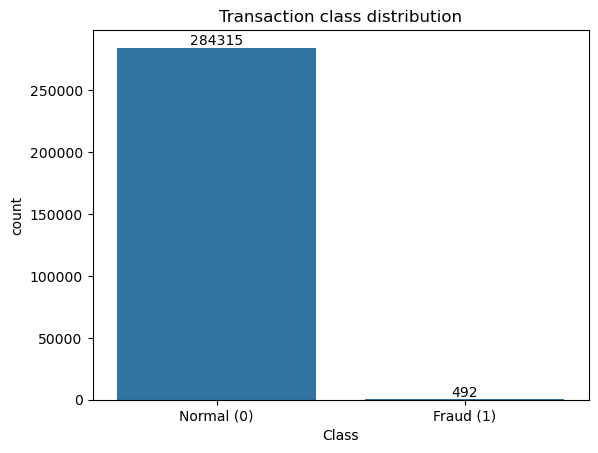

In [6]:
# label 확인 - sol2
sns.countplot(data=df, x='Class')
plt.title('Transaction class distribution')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])

class_counts = df['Class'].value_counts() # (Class, Count)
for i, count in enumerate(class_counts):
    # x축, y축, text, 정렬 옵션, 사이즈
    plt.text(i, count + 2000, f'{count}', ha='center', fontsize=10)
    
plt.show()

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

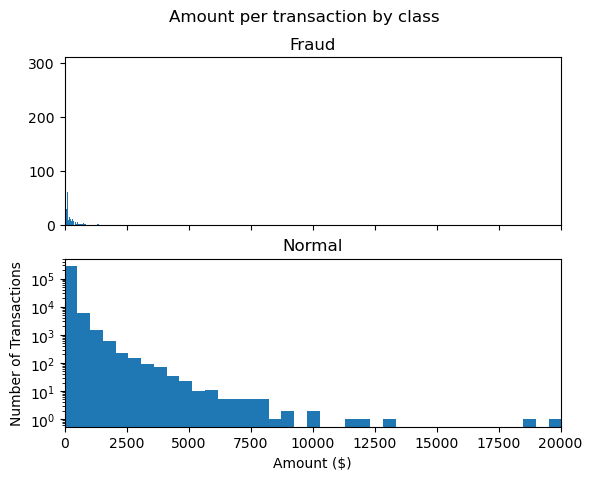

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

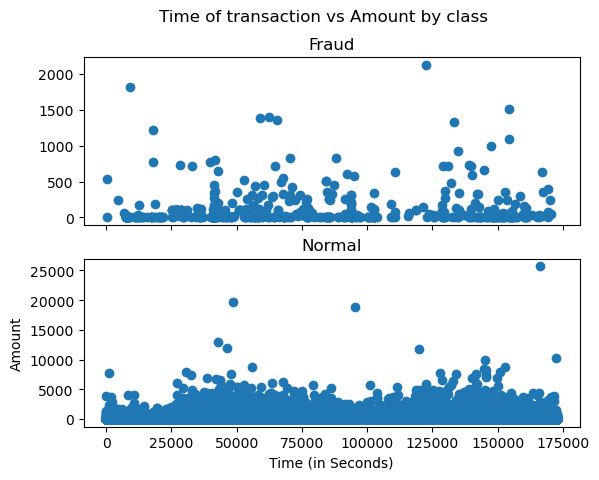

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

data = df.drop('Time', axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# 2. Autoencoder

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, 
                                     test_size=0.2,
                                     random_state=42)

In [12]:
# 훈련에는 label이 0인 X만 사용
df_train_0 = df_train[df_train['Class'] == 0]
X_train = df_train_0.drop('Class', axis=1).to_numpy()

# 테스트에는 label 0과 1이 모두 존재
# 목표는 1을 감지하는 것
X_test = df_test.drop('Class', axis=1).to_numpy()
y_test = df_test['Class'].to_numpy()

print(f'X_train.shape {X_train.shape} \nX_test.shape {X_test.shape}')

X_train.shape (227451, 29) 
X_test.shape (56962, 29)


In [13]:
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)
bottleneck_dim = int(encoding_dim / 2)

num_epochs = 50
batch_size = 256

In [14]:
import tensorflow as tf
import tensorflow.keras as keras

autoencoder = keras.Sequential(name='autoencoder')
# encoder
autoencoder.add(keras.layers.Input(shape=(input_dim,)))
autoencoder.add(keras.layers.Dense(encoding_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(bottleneck_dim, activation='relu'))
# decoder
autoencoder.add(keras.layers.Dense(bottleneck_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(encoding_dim, activation='relu'))
autoencoder.add(keras.layers.Dense(input_dim, activation='sigmoid'))

autoencoder.summary()

2024-10-06 20:36:15.436295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                420       
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 7)                 56        
                                                                 
 dense_3 (Dense)             (None, 14)                112       
                                                                 
 dense_4 (Dense)             (None, 29)                435       
                                                                 
Total params: 1,128
Trainable params: 1,128
Non-trainable params: 0
_________________________________________________________________


2024-10-06 20:36:18.797370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
autoencoder.compile(optimizer='adam',
                    loss='mse')

In [16]:
history = autoencoder.fit(X_train, X_train,
                          validation_split=0.1,
                          epochs=num_epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          verbose=2)

Epoch 1/50
800/800 - 1s - loss: 1.0026 - val_loss: 0.8987 - 1s/epoch - 2ms/step
Epoch 2/50
800/800 - 1s - loss: 0.8957 - val_loss: 0.8692 - 735ms/epoch - 919us/step
Epoch 3/50
800/800 - 1s - loss: 0.8819 - val_loss: 0.8592 - 762ms/epoch - 953us/step
Epoch 4/50
800/800 - 1s - loss: 0.8730 - val_loss: 0.8542 - 767ms/epoch - 959us/step
Epoch 5/50
800/800 - 1s - loss: 0.8691 - val_loss: 0.8495 - 788ms/epoch - 986us/step
Epoch 6/50
800/800 - 1s - loss: 0.8636 - val_loss: 0.8447 - 765ms/epoch - 956us/step
Epoch 7/50
800/800 - 1s - loss: 0.8593 - val_loss: 0.8402 - 740ms/epoch - 924us/step
Epoch 8/50
800/800 - 1s - loss: 0.8549 - val_loss: 0.8369 - 743ms/epoch - 929us/step
Epoch 9/50
800/800 - 1s - loss: 0.8521 - val_loss: 0.8348 - 745ms/epoch - 931us/step
Epoch 10/50
800/800 - 1s - loss: 0.8503 - val_loss: 0.8332 - 747ms/epoch - 933us/step
Epoch 11/50
800/800 - 1s - loss: 0.8487 - val_loss: 0.8319 - 737ms/epoch - 921us/step
Epoch 12/50
800/800 - 1s - loss: 0.8475 - val_loss: 0.8304 - 734ms/e

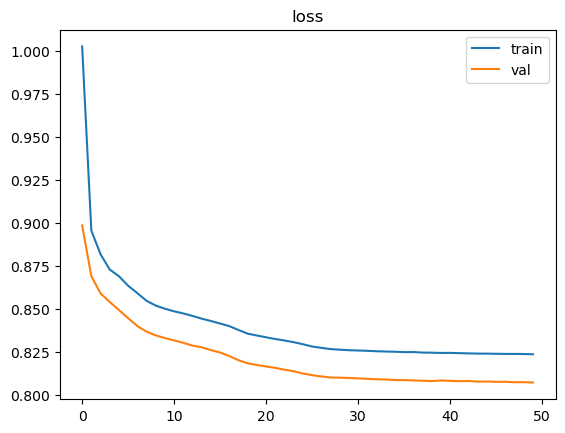

In [17]:
# epoch에 따른 loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'val')
plt.title('loss')
plt.legend() # 우측 상단에 그래프 정보 띄워주는 거
plt.show()

In [18]:
# valid_x에 대한 reconstruced data
predictions = autoencoder.predict(X_test) 
# original data와 reconstruced data의 MSE 즉, reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1) 
                                                                                   
# reconstruction error에 따른 Fraud 여부를 저장할 dataframe 생성
error_df = pd.DataFrame({'Reconstruction_error': mse, # reconstruction error와
                        'True_class': y_test})        # 그때의 Fraud 여부

error_df

1781/1781 [==============================] - 1s 571us/step


,Reconstruction_error,True_class
0,81.340030,1
1,0.928628,0
2,0.266920,0
3,0.334201,0
4,0.196482,0
...,...,...
56957,0.691679,0
56958,0.196807,0
56959,0.543063,0
56960,0.127218,0


In [19]:
# Fraud 유무에 따른 Reconstruction_error 확인 - Fraud일 때
error_df[error_df['True_class'] == 1]

,Reconstruction_error,True_class
0,81.340030,1
565,4.770523,1
3025,9.014748,1
3228,1.547434,1
4178,2.157570,1
...,...,...
55799,96.768592,1
56196,17.265453,1
56282,4.046267,1
56288,5.503188,1


In [20]:
# Fraud 유무에 따른 Reconstruction_error 확인 - 정상일 때
error_df[error_df['True_class'] == 0]

,Reconstruction_error,True_class
1,0.928628,0
2,0.266920,0
3,0.334201,0
4,0.196482,0
5,1.105584,0
...,...,...
56957,0.691679,0
56958,0.196807,0
56959,0.543063,0
56960,0.127218,0


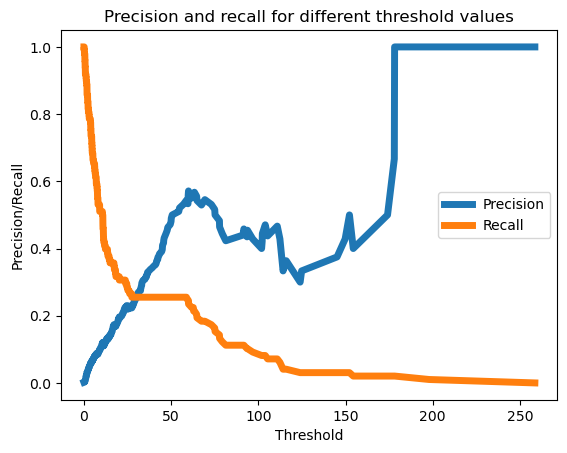

In [21]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve 함수는 함수 내에서 threshold(임계값)를 임의로 지정하면서
# 해당 임계값을 기준으로 dataset을 0 or 1로 분류했을 때의 precision과 recall 값을 리턴한다.
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

- **정밀도(Precision):**  
  모델이 양성(positive) 으로 예측한 샘플들 중에서 실제로 양성인 비율입니다.  
  예를 들어, 모델이 sheet-break(고장)를 예측한 모든 경우 중에서 실제로 고장이 발생한 비율.  
  Precision = (True Positives) / (True Positives + False Positives)

- **재현율(Recall):**  
  실제로 양성인 샘플들 중에서 모델이 올바르게 양성으로 예측한 비율입니다.  
  즉, 실제 고장이 발생한 모든 경우 중에서 모델이 얼마나 잘 고장을 예측했는지를 나타냅니다.  
  Recall = (True Positives) / (True Positives + False Negatives)

- **임계값(Threshold):**
  모델이 예측을 양성으로 판단할 기준 점수입니다.  
  예를 들어, Autoencoder의 재구성 오류가 특정 임계값을 넘으면 고장으로 예측하는 방식입니다.  
  임계값을 변경함에 따라 정밀도와 재현율이 달라집니다.

> 임계값이 낮으면 더 많은 샘플을 양성으로 예측하지만, 그 중에 잘못된 예측(거짓 양성, False Positives)이 많아질 수 있습니다.  
> 임계값이 높으면 예측의 신뢰도는 증가하지만, 실제로 양성인 것을 놓치는 경우(거짓 음성, False Negatives)가 많아질 수 있습니다.

```
- precision   | TP / (TP + FP)
- recall      | TP / (TP + FN)
- f1-score    | harmonic mean of precision and recall
                (2 * (precision * recall)) / (precision + recall)
                일반적으로 precision과 recall은 trade-off 관계라서
                이를 절충할 수 있도록 한 개념임
- accuracy    | (TP + TN) / (TP + TN + FP + FN)
```

해당 task에서는 **Fraud를 예측하지 못했을 때**의 손실이 매우 크다.  
따라서 FP(Fraud 아닌데, Fraud라고 예측)가 조금 높아지더라도 FN(Fraud인데, Fraud 아니라고 예측 -> 예측하지 못한 Fraud로 인해 더 큰 손실 발생)을 낮추는 것이 중요하다.  

> 임계값이 낮으면 더 많은 샘플을 양성으로 예측하지만, 그 중에 잘못된 예측(거짓 양성, False Positives)이 많아질 수 있습니다.  
> 임계값이 높으면 예측의 신뢰도는 증가하지만, 실제로 양성인 것을 놓치는 경우(거짓 음성, False Negatives)가 많아질 수 있습니다.

따라서 임계값을 낮추는 방향으로 판단하는 것이 적절하다.  
즉 FP를 늘리는 방향으로 가야 되니까, precision이 낮아지는 방향 또는 recall이 높아지는 방향으로 판단하면 된다.  

FP인 경우에는 그냥 점검 한 번 더 했다고 치고, 잠깐 점검하는 시간 만큼만 손해보면 된다.  
FN인 경우에는 FP로 인한 점검으로 발생하는 조금의 손해는 줄일 수 있지만, 실제 Fraud 발생으로 인한 큰 손해를 보게 된다.

In [22]:
# threshold 값을 조정하여 최선의 정확도를 얻음, 그래프를 보고 결정
# 일단 reconstruction error가 15를 넘으면 Fraud로 분류하도록 설정
threshold = 15

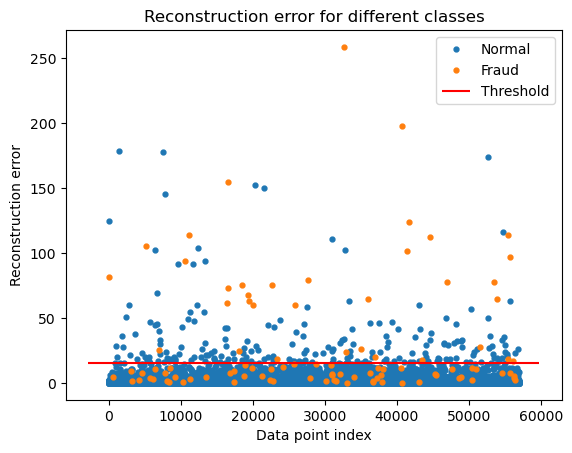

In [23]:
# y값 필터링
# error_df_test = error_df_test.reset_index()

groups = error_df.groupby('True_class')  # True_class별로 그룹화

fig, ax = plt.subplots()

# 각 클래스 그룹에 대해 점들을 플로팅
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")

# 고정된 임계값을 빨간 선으로 표시
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Y축 범위를 100 이하로 설정
# ax.set_ylim(0, 15)

# 범례, 제목, 축 레이블 설정
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

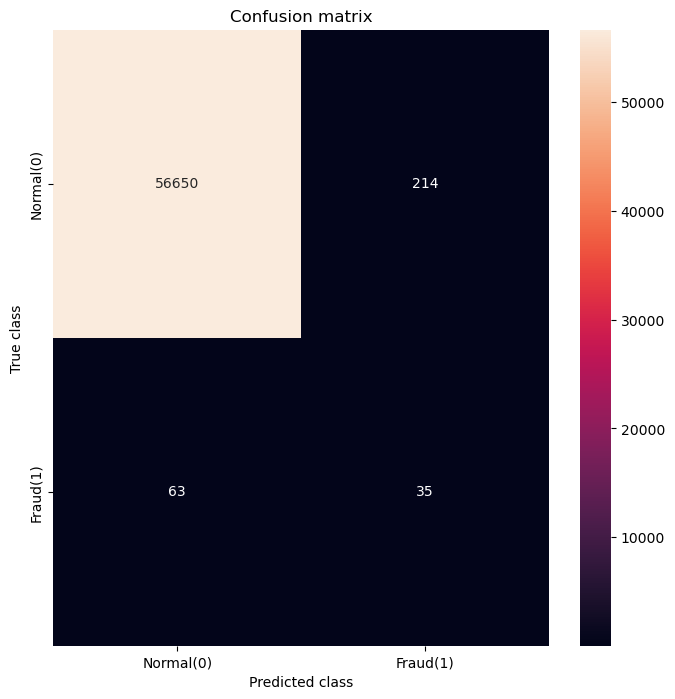

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.14      0.36      0.20        98

    accuracy                           1.00     56962
   macro avg       0.57      0.68      0.60     56962
weighted avg       1.00      1.00      1.00     56962



In [24]:
from sklearn.metrics import confusion_matrix, classification_report

LABELS = ['Normal(0)', 'Fraud(1)']
y_pred = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.True_class, y_pred))